# Data formating

In [1]:
import os
import pickle
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# load training images with numpy
images_train = np.load('train_images.npy', encoding='latin1')
print("Training image shape: ",images_train.shape)
print("Training image shape: ",images_train.dtype)
print("Image format: ", (images_train[:][1]))

# load labels with numpy
train_labels = np.genfromtxt('train_labels.csv', names=True, delimiter=',', dtype=[('Id', 'i8'), ('Category', 'S5')])
print("Training labels shape: ", train_labels.shape)

#Reshaping image to 100x100
image_train1 = (images_train[32][1]).reshape(100,100)
plt.imshow(image_train1)


Training image shape:  (10000, 2)
Training image shape:  object
Image format:  [1 array([0., 0., 0., ..., 0., 0., 0.])]
Training labels shape:  (10000,)


In [2]:
#Printing label
number_of_classes = np.unique(train_labels['Category']).size
print("Number of classes: ", number_of_classes)
# Mapping string name to class number:

class_names = np.unique(train_labels['Category'])
print(class_names)

def get_class_nb(lable):
    return np.argwhere(class_names == lable).item()

def get_class_name(indx):
    return class_names[indx]

class_nb_example = get_class_nb(train_labels[0]['Category'])
print()
print("Example: ", train_labels[0]['Category'], " is class number ", class_nb_example)
print("Example reverse:", class_nb_example, " is ", get_class_name(class_nb_example))


Number of classes:  31
[b'apple' b'empty' b'moust' b'mouth' b'mug' b'nail' b'nose' b'octag'
 b'paint' b'panda' b'parro' b'peanu' b'pear' b'penci' b'pengu' b'pillo'
 b'pinea' b'pool' b'rabbi' b'rhino' b'rifle' b'rolle' b'sailb' b'scorp'
 b'screw' b'shove' b'sink' b'skate' b'skull' b'spoon' b'squig']

Example:  b'shove'  is class number  25
Example reverse: 25  is  b'shove'


In [3]:
# Replace string labels with class numbers
# To map it back to the lable, use get_class_name




Image shape:  (10000, 2)
Image ID:  0


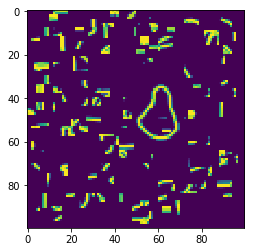

In [4]:
#Load test images with numpy
images_test = np.load('test_images.npy', encoding='latin1')
print("Image shape: ", images_test.shape)

# Reshape test images
print("Image ID: ", images_test[0][0])
image_test1 = (images_test[1][1]).reshape(100,100)
plt.imshow(image_test1)

In [5]:
# If a GPU is available, use it
# Pytorch uses an elegant way to keep the code device agnostic
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
# debugging
# device = torch.device("cpu")
# use_cuda = False
    
print(device)

cuda


In [6]:
# Converting numpy array to pytorch
# End result for tensor size -> (10000, 1, 100, 100) <=> (nb examples, nb chanels, width, height)
train_tensor = torch.stack([torch.Tensor(np.array(i).reshape((1, 100, 100))) for i in (images_train[:,1])])#.to(device)
test_tensor = torch.stack([torch.Tensor(np.array(i).reshape((1, 100, 100))) for i in (images_test[:,1])])#.to(device)

train_label_converted = np.stack([get_class_nb(i) for i in train_labels["Category"]])
label_tensor = torch.from_numpy(train_label_converted).long()#.to(device)


# Creating Pytoch Data Loaders

In [7]:
# Creating dataloaders
import torch.utils.data as data_utils
from torch.utils.data.sampler import (SubsetRandomSampler,
                                      RandomSampler)

batch_size=50
# This is the subset of Kaggle images we want to overfit
train = data_utils.TensorDataset(train_tensor, label_tensor)
train_loader = data_utils.DataLoader(train, batch_size=batch_size, pin_memory=True) # shuffle=True, cuda

scratch_loader = data_utils.DataLoader(
    train,
    batch_size=batch_size,
    # The sampler is an easy way to say that we're using the elements
    # `indices[:n_scratch]` for this loader
    # sampler=SubsetRandomSampler(indices[:n_scratch]),
    shuffle=True,
    num_workers=1,
    pin_memory=True # Cuda
)

This is the shape of one batch of inputs torch.Size([50, 1, 100, 100])
This is the shape of one batch of targets torch.Size([50])
This is an image of class b'shove'


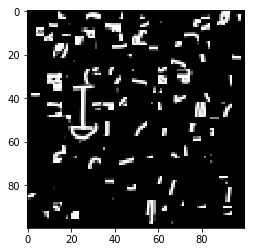

In [8]:
# Validating dataloader format
for inputs, targets in train_loader:
    print(f"This is the shape of one batch of inputs {inputs.shape}")
    print(f"This is the shape of one batch of targets {targets.shape}")
    print("This is an image of class", get_class_name(int(targets[0])))

#           " What is the meaning of each dimension?")
#     print("target", targets.shape, targets)
    img = inputs[0][0]
    plt.imshow(img, cmap='Greys_r')
    break

# Model definition

In [9]:
class BasicNet(nn.Module):
    """Affordable convolutions for the people."""
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(10,10), padding=2, stride=1)
        self.bn = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 256, 6, padding=2)
        self.bn2 = nn.BatchNorm2d(256)
        
        self.conv3 = nn.Conv2d(256, 256 + 64, 4, padding=1)
        self.bn3 = nn.BatchNorm2d(256 + 64)
        
        self.fc = nn.Linear(320, 10)

    def forward(self, xin):
        # x is [batch_size, channels, heigth, width] = [bs, 1, 28, 28]
        x = F.relu(self.bn(self.conv1(xin)))
        x = F.max_pool2d(x, 4) 
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 4) 
        
        # x is [bs, 32, 14, 14]
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 4) 
        
        # x is [bs, 64, 7, 7]
        x = x.view(x.size(0), -1) # flatten
        x = F.relu(self.fc(x))
        return x

# Training

In [10]:
# Surrogate loss used for training
loss_fn = nn.CrossEntropyLoss()
test_loss_fn = nn.CrossEntropyLoss(reduction='sum')

# spot to save your learning curves, and potentially checkpoint your models
savedir = 'results'
if not os.path.exists(savedir):
    os.makedirs(savedir)

## This method comes from the lab session number 11 of the class
def train(model, train_loader, optimizer, epoch ):
    """Perform one epoch of training."""
    model.train()
    
    for batch_idx, (inputs, target) in enumerate(train_loader):
        inputs, target = inputs.to(device), target.to(device) # Send data to the device
        
        optimizer.zero_grad()
        output = model.forward(inputs)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader) *len(inputs) ,
                100. * batch_idx / len(train_loader), loss.item()))

In [11]:
## This method comes from the lab session number 11 of the class
def test(model, test_loader):
    """Evaluate the model by doing one pass over a dataset"""
    model.eval()
    
    test_loss = 0
    correct = 0
    test_size = 0
    
    with torch.no_grad(): # save some computations
      
        for inputs, target in test_loader:
            inputs, target = inputs.to(device), target.to(device)
            test_size += target.size(0)

            output = model(inputs)
            loss = test_loss_fn(output, target)
            test_loss += loss
            
            pred = output.max(1, keepdim=True)[1]# [1] return s the arg max. i.e.  si idx == target, get the index of the prediction
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= test_size
    accuracy = correct / test_size
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_size,
        100. * accuracy))
    
    return test_loss, accuracy

In [12]:
model = BasicNet().to(device)

lr = 0.0005
optimizer = optim.Adam(model.parameters(), lr=lr)

results = {'name':'basic', 'lr': lr, 'loss': [], 'accuracy':[]}
savefile = os.path.join(savedir, results['name']+str(results['lr'])+'.pkl' )

for epoch in range(2):
    train(model, scratch_loader, optimizer, epoch)
    loss, acc = test(model, scratch_loader)
    
    # save results every epoch
    results['loss'].append(loss)
    results['accuracy'].append(acc)
    with open(savefile, 'wb') as fout:
        pickle.dump(results, fout)

Train Epoch: 1 [0/10000 (0%)]	Loss: 2.348259
Train Epoch: 1 [500/10000 (5%)]	Loss: 2.283693
Train Epoch: 1 [1000/10000 (10%)]	Loss: 2.297288
Train Epoch: 1 [1500/10000 (15%)]	Loss: 2.257850
Train Epoch: 1 [2000/10000 (20%)]	Loss: 2.299341
Train Epoch: 1 [2500/10000 (25%)]	Loss: 2.199073
Train Epoch: 1 [3000/10000 (30%)]	Loss: 2.302584
Train Epoch: 1 [3500/10000 (35%)]	Loss: 2.210481
Train Epoch: 1 [4000/10000 (40%)]	Loss: 2.210481
Train Epoch: 1 [4500/10000 (45%)]	Loss: 2.256533
Train Epoch: 1 [5000/10000 (50%)]	Loss: 2.210481
Train Epoch: 1 [5500/10000 (55%)]	Loss: 2.210481
Train Epoch: 1 [6000/10000 (60%)]	Loss: 2.210481
Train Epoch: 1 [6500/10000 (65%)]	Loss: 2.256533
Train Epoch: 1 [7000/10000 (70%)]	Loss: 2.256533
Train Epoch: 1 [7500/10000 (75%)]	Loss: 2.256533
Train Epoch: 1 [8000/10000 (80%)]	Loss: 2.256533
Train Epoch: 1 [8500/10000 (85%)]	Loss: 2.302584
Train Epoch: 1 [9000/10000 (90%)]	Loss: 2.256533
Train Epoch: 1 [9500/10000 (95%)]	Loss: 2.210481
Test set: Average loss: 2.